# Keras Mobilenet 版的遷移學習範例 #
背景說明請見 [玩具烏托邦短文](https://newtoypia.blogspot.com/2019/10/transfer-learning.html)。 本 ipynb 文件修改自 [erhat00/Deep-Learning](https://github.com/ferhat00/Deep-Learning/tree/master/Transfer%20Learning%20CNN)
也大推原作者的 [教學文](https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299)。 

前置作業：
1. 下載 [ckhung/keras-mobilenet](https://github.com/ckhung/keras-mobilenet)， 再上傳到你的 google drive。 假設放在 drive 的 colab/keras-mobilenet/ 目錄底下。
1. 假設你先前已玩過 [google colab](https://newtoypia.blogspot.com/2019/07/colab.html)， 那麼現在從 google drive 裡面打開 km-transfer.ipynb 應該就會自動進入 colab。 (你已做到這一步)
1. 從 colab 的 Edit => Notebook Settings 進去，把 Hardware accelerator 設定成 GPU。
1. 掛載 google drive：

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser:
Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir('/content/drive/My Drive/colab/keras-mobilenet')

載入相依套件：

In [3]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam


Using TensorFlow backend.


建立 MobileNet。 原始論文： [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision
Applications, Howard et al, 2017
](https://arxiv.org/pdf/1704.04861.pdf)


In [4]:
mobile = keras.applications.mobilenet.MobileNet()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
17227776/17225924 [==============================] - 2s 0us/step


In [5]:
!ls -l /root/.keras/models # 剛剛下載的權重矩陣放在這裡

total 16824
-rw-r--r-- 1 root root 17225924 Oct 13 02:06 mobilenet_1_0_224_tf.h5


In [0]:
def prepare_image(image_path, show=True):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    if show:
        display(Image(filename=image_path))
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

def mobile_cl(image_path, show=True):
    prepared = prepare_image(image_path, show)
    ans = mobile.predict(prepared)
    return imagenet_utils.decode_predictions(ans)


以下幾張圖片的狗狗所屬的品種都落在 [1000類標籤](https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json) 當中。 為了節省空間，我用 show=False 阻止畫圖。 (除了柴犬那一張)

In [43]:
mobile_cl('quiz/0-german_shepherd.jpg',show=False)

[[('n02106662', 'German_shepherd', 0.9796372),
  ('n02105162', 'malinois', 0.020184083),
  ('n02091467', 'Norwegian_elkhound', 0.00015799515),
  ('n02116738', 'African_hunting_dog', 5.2901587e-06),
  ('n02105251', 'briard', 3.9127376e-06)]]

In [44]:
mobile_cl('quiz/0-labrador1.jpg',show=False)

[[('n02099712', 'Labrador_retriever', 0.73073715),
  ('n02087394', 'Rhodesian_ridgeback', 0.03984368),
  ('n02092339', 'Weimaraner', 0.033590093),
  ('n02109047', 'Great_Dane', 0.028944712),
  ('n02110341', 'dalmatian', 0.022403585)]]

In [45]:
mobile_cl('quiz/0-poodle1.jpg',show=False) 

[[('n02113799', 'standard_poodle', 0.56509113),
  ('n02113712', 'miniature_poodle', 0.37279928),
  ('n02102973', 'Irish_water_spaniel', 0.053150624),
  ('n02113624', 'toy_poodle', 0.00721463),
  ('n02093859', 'Kerry_blue_terrier', 0.0013652635)]]

但是1000類標籤竟然不包含可愛的柴犬！

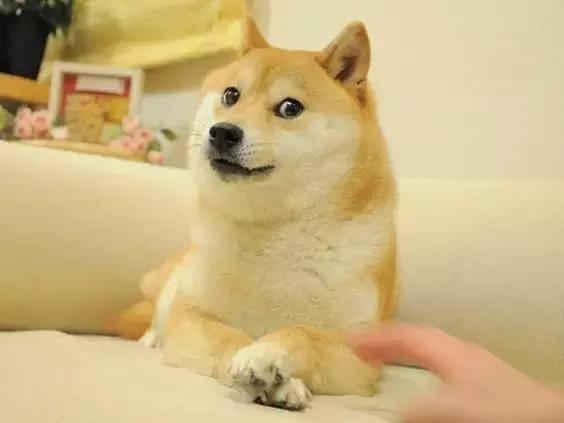

[[('n02113023', 'Pembroke', 0.41327956),
  ('n02110806', 'basenji', 0.35777965),
  ('n02115641', 'dingo', 0.08982951),
  ('n02085620', 'Chihuahua', 0.086097196),
  ('n02113186', 'Cardigan', 0.011335891)]]

In [46]:
mobile_cl('quiz/0-shiba-inu.jpg',show=True) 

以下要拿 MobileNet 來做遷移學習， 改訓練成狗狗動作判別器， 判斷一張圖片當中的狗正在做哪一件事： [其他、 跳、 睡、 游泳、 甩水、 伸展、 尿尿] 。 去除原本的輸出層 (top， 最下游那一層)、 替換成三層 fully connected layers， 以及含有七個 neurons 的新的輸出層。

In [18]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(7,activation='softmax')(x) #final layer with softmax activation
dog_behavior = Model(inputs=base_model.input,outputs=preds)


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 3s 0us/step


In [19]:
!ls -l /root/.keras/models # 這次下載的權重矩陣是 「無頂版」 (no_top)， 但是目前只存在於記憶體內。

total 33684
-rw-r--r-- 1 root root    35363 Oct 13 02:07 imagenet_class_index.json
-rw-r--r-- 1 root root 17225924 Oct 13 02:06 mobilenet_1_0_224_tf.h5
-rw-r--r-- 1 root root 17225924 Oct 13 02:21 mobilenet_1_0_224_tf_no_top.h5


畫圖： 從 [官網文件](https://keras.io/zh/visualization/)  和 [StackOverflow](https://stackoverflow.com/questions/51452569/how-to-resize-rescale-a-svg-graphic-in-an-ipython-jupyter-notebook) 學到如何把模型用 svg 格式畫出來並指定圖形大小。

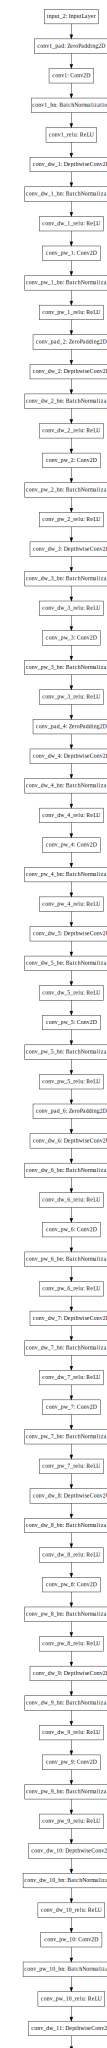

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model_dot = model_to_dot(dog_behavior)
model_dot.set_size('30')
SVG(model_dot.create(prog='dot', format='svg'))


 畫圖的效果好像不太好， 會被截掉。 算了， 反正結構很單純， 還是直接印文字版好了：

In [0]:
for i,layer in enumerate(dog_behavior.layers):
  print(i,layer.name)

0 input_2
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

鎖住上游大部分的權重(保留既有、訓練好的權重)，只訓練/改變最下游四層的權重。

In [0]:
for layer in dog_behavior.layers:
    layer.trainable=False
for layer in dog_behavior.layers[-4:]:
    layer.trainable=True

[用 google-images-download 下載訓練用的圖片](https://newtoypia.blogspot.com/2019/10/google-images-download.html) ， 把圖片目錄上傳到 drive 的 /colab/dog_behaviors/ 。 我簡化了目錄名稱， 並且在前面加上數字， 比較方便對照。

In [25]:
!ls ../dog_behaviors/

0_other  1_jump  2_sleep  3_swim  4_shake  5_stretch  6_pee


把訓練圖片目錄 ../dog_behaviors/ 餵給 ImageDataGenerator：

In [26]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(
    '../dog_behaviors', target_size=(224,224), batch_size=32,
    class_mode='categorical', color_mode='rgb', shuffle=True
)
label2id = train_generator.class_indices
id2label = [label2id[x] for x in label2id]
id2label = dict((v,k) for k,v in label2id.items())

Found 464 images belonging to 7 classes.


編譯完模型之後， 在 google colab 上用 GPU 訓練， 大約五分鐘。

In [27]:
dog_behavior.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
dog_behavior.fit_generator(
    generator=train_generator,
    steps_per_epoch=step_size_train,
    epochs=10
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
14/14 [==============================] - 178s 13s/step - loss: 1.8702 - acc: 0.3907
Epoch 2/10
14/14 [==============================] - 20s 1s/step - loss: 0.8882 - acc: 0.6875
Epoch 3/10
14/14 [==============================] - 7s 509ms/step - loss: 0.5993 - acc: 0.8036
Epoch 4/10
14/14 [==============================] - 7s 496ms/step - loss: 0.3628 - acc: 0.8868
Epoch 5/10
14/14 [==============================] - 7s 480ms/step - loss: 0.2336 - acc: 0.9353
Epoch 6/10
14/14 [==============================] - 7s 494ms/step - loss: 0.1364 - acc: 0.9644
Epoch 7/10
14/14 [==============================] - 7s 504ms/step - loss: 0.0859 - acc: 0.9799
Epoch 8/10
14/14 [==============================] - 6s 456ms/step - loss: 0.1127 - acc: 0.9580
Epoch 9/10
14/14 [==============================] - 7s 496ms/step - loss: 0.2242 - acc: 0.9468
Epoch 10/10
14/14 [==============================

測試已訓練好的 dog_behavior 模型

In [0]:
def behavior_cl(image_path, show=True):
    prepared = prepare_image(image_path, show)
    ans = dog_behavior.predict(prepared)[0]
    best = sorted(range(len(ans)), key=lambda k: -ans[k])[:5]
    return ['{:6.2f}% {}'.format(ans[id]*100,id2label[id]) for id in best]


In [32]:
from glob import glob
for f in sorted(glob('quiz/*.jpg')):
    print(f, behavior_cl(f,show=False))

quiz/0-german_shepherd.jpg [' 46.96% 0_other', ' 35.10% 6_pee', '  8.59% 4_shake', '  3.59% 1_jump', '  3.08% 5_stretch']
quiz/0-labrador1.jpg [' 93.78% 0_other', '  3.90% 5_stretch', '  1.12% 6_pee', '  0.50% 2_sleep', '  0.37% 3_swim']
quiz/0-poodle1.jpg [' 61.31% 0_other', ' 31.56% 4_shake', '  2.61% 6_pee', '  1.93% 2_sleep', '  1.45% 1_jump']
quiz/0-shiba-inu.jpg [' 84.38% 2_sleep', ' 15.49% 0_other', '  0.04% 3_swim', '  0.03% 4_shake', '  0.03% 1_jump']
quiz/jump-1.jpg [' 98.98% 1_jump', '  0.61% 4_shake', '  0.23% 3_swim', '  0.12% 0_other', '  0.03% 6_pee']
quiz/jump-2.jpg [' 96.59% 1_jump', '  1.55% 0_other', '  0.77% 4_shake', '  0.38% 5_stretch', '  0.35% 6_pee']
quiz/pee-1.jpg [' 77.55% 5_stretch', '  8.07% 6_pee', '  5.95% 4_shake', '  2.71% 0_other', '  2.04% 3_swim']
quiz/pee-2.jpg [' 94.89% 6_pee', '  2.15% 0_other', '  1.30% 5_stretch', '  1.17% 4_shake', '  0.22% 1_jump']
quiz/shake-1.jpg [' 99.92% 4_shake', '  0.06% 0_other', '  0.01% 2_sleep', '  0.01% 1_jump', '  

In [0]:
dog_behavior.save('dog_behavior.h5')

In [37]:
!ls -l /root/.keras/models # 咦，剛剛下載的「無頂版」出現了； 可是我們自己存的權重矩陣呢？

total 33684
-rw-r--r-- 1 root root    35363 Oct 13 02:07 imagenet_class_index.json
-rw-r--r-- 1 root root 17225924 Oct 13 02:06 mobilenet_1_0_224_tf.h5
-rw-r--r-- 1 root root 17225924 Oct 13 02:21 mobilenet_1_0_224_tf_no_top.h5


In [40]:
!find / -iname 'dog*.h5' -ls # 原來放在目前工作目錄底下

    16422  43678 -rw-------   1 root     root     44725616 Oct 13 02:49 /content/drive/My\ Drive/colab/keras-mobilenet/dog_behavior.h5


也請參考： [Keras 儲存與載入訓練好的模型或參數教學](https://blog.gtwang.org/programming/keras-save-and-load-model-tutorial/)